In [22]:
# Load initial libraries
import numpy as np
import pandas as pd
import sklearn.metrics as skm
import sklearn as sk
from matplotlib import pyplot as plt
import xgboost as xgb
from sklearn import tree

import seaborn as sns
import csv


from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor


Notebook format:

1. EDA


Notes:
Different credit scoring methods apply different weights to features when determining score, what weights were used for determining ours? Each feature weighted equally?

Could experiment with different weightings according to FICO & VantageScore as they are public, only Credit Bureaus are not for public.

In [4]:
# Raw dataset Exploration

# Read dataset into dataframe
german = pd.read_csv('/Users/coletteford/Desktop/IGP/Dataset/german.csv')



# Review formatting of dataframe
german.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 24 columns):
 #   Column                                                    Non-Null Count  Dtype 
---  ------                                                    --------------  ----- 
 0   Duration in month                                         1000 non-null   int64 
 1   Credit amount                                             1000 non-null   int64 
 2   Installment rate in percentage of disposable income       1000 non-null   int64 
 3   Present residence since                                   1000 non-null   int64 
 4   Age                                                       1000 non-null   int64 
 5   Number of existing credits at this bank                   1000 non-null   int64 
 6   Number of people being liable to provide maintenance for  1000 non-null   int64 
 7   Status of existing checking account                       1000 non-null   object
 8   Credit history               

Raw Dataset Exploration:

24 columns excluding index
8 integer columns
16 object columns - categorical

Duplicates:
Outcome / Risk(Outcome_text)

In [5]:
# Initial cleaning

# Drop empty fields
german.dropna(inplace=True)

# Drop duplicate columns
german = german.drop('Outcome', axis='columns')
german = german.drop('Personal status and sex', axis='columns')

# rename target variable
german['Outcome'] = german['Risk(Outcome_text)'] 



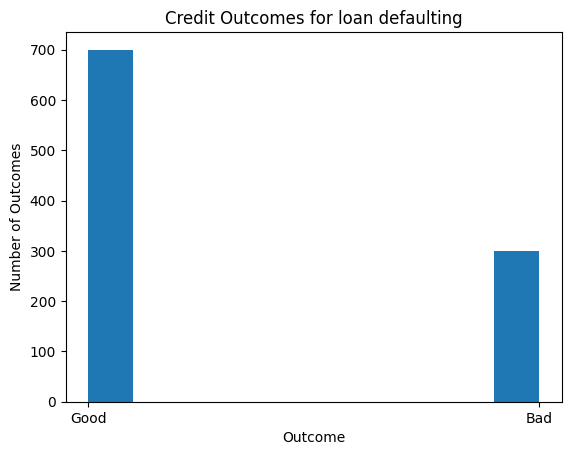

<Figure size 640x480 with 0 Axes>

In [6]:
# Identify target variable
y = german['Outcome']
X = german.drop('Outcome', axis='columns')
# Take a look at target variable

plt.hist(y)
plt.title('Credit Outcomes for loan defaulting')
plt.xlabel('Outcome')
plt.ylabel('Number of Outcomes')
plt.show()
plt.clf()

Target variable has a ratio of 7:3. This is considered marginally unbalanced and for now no action will be taken.

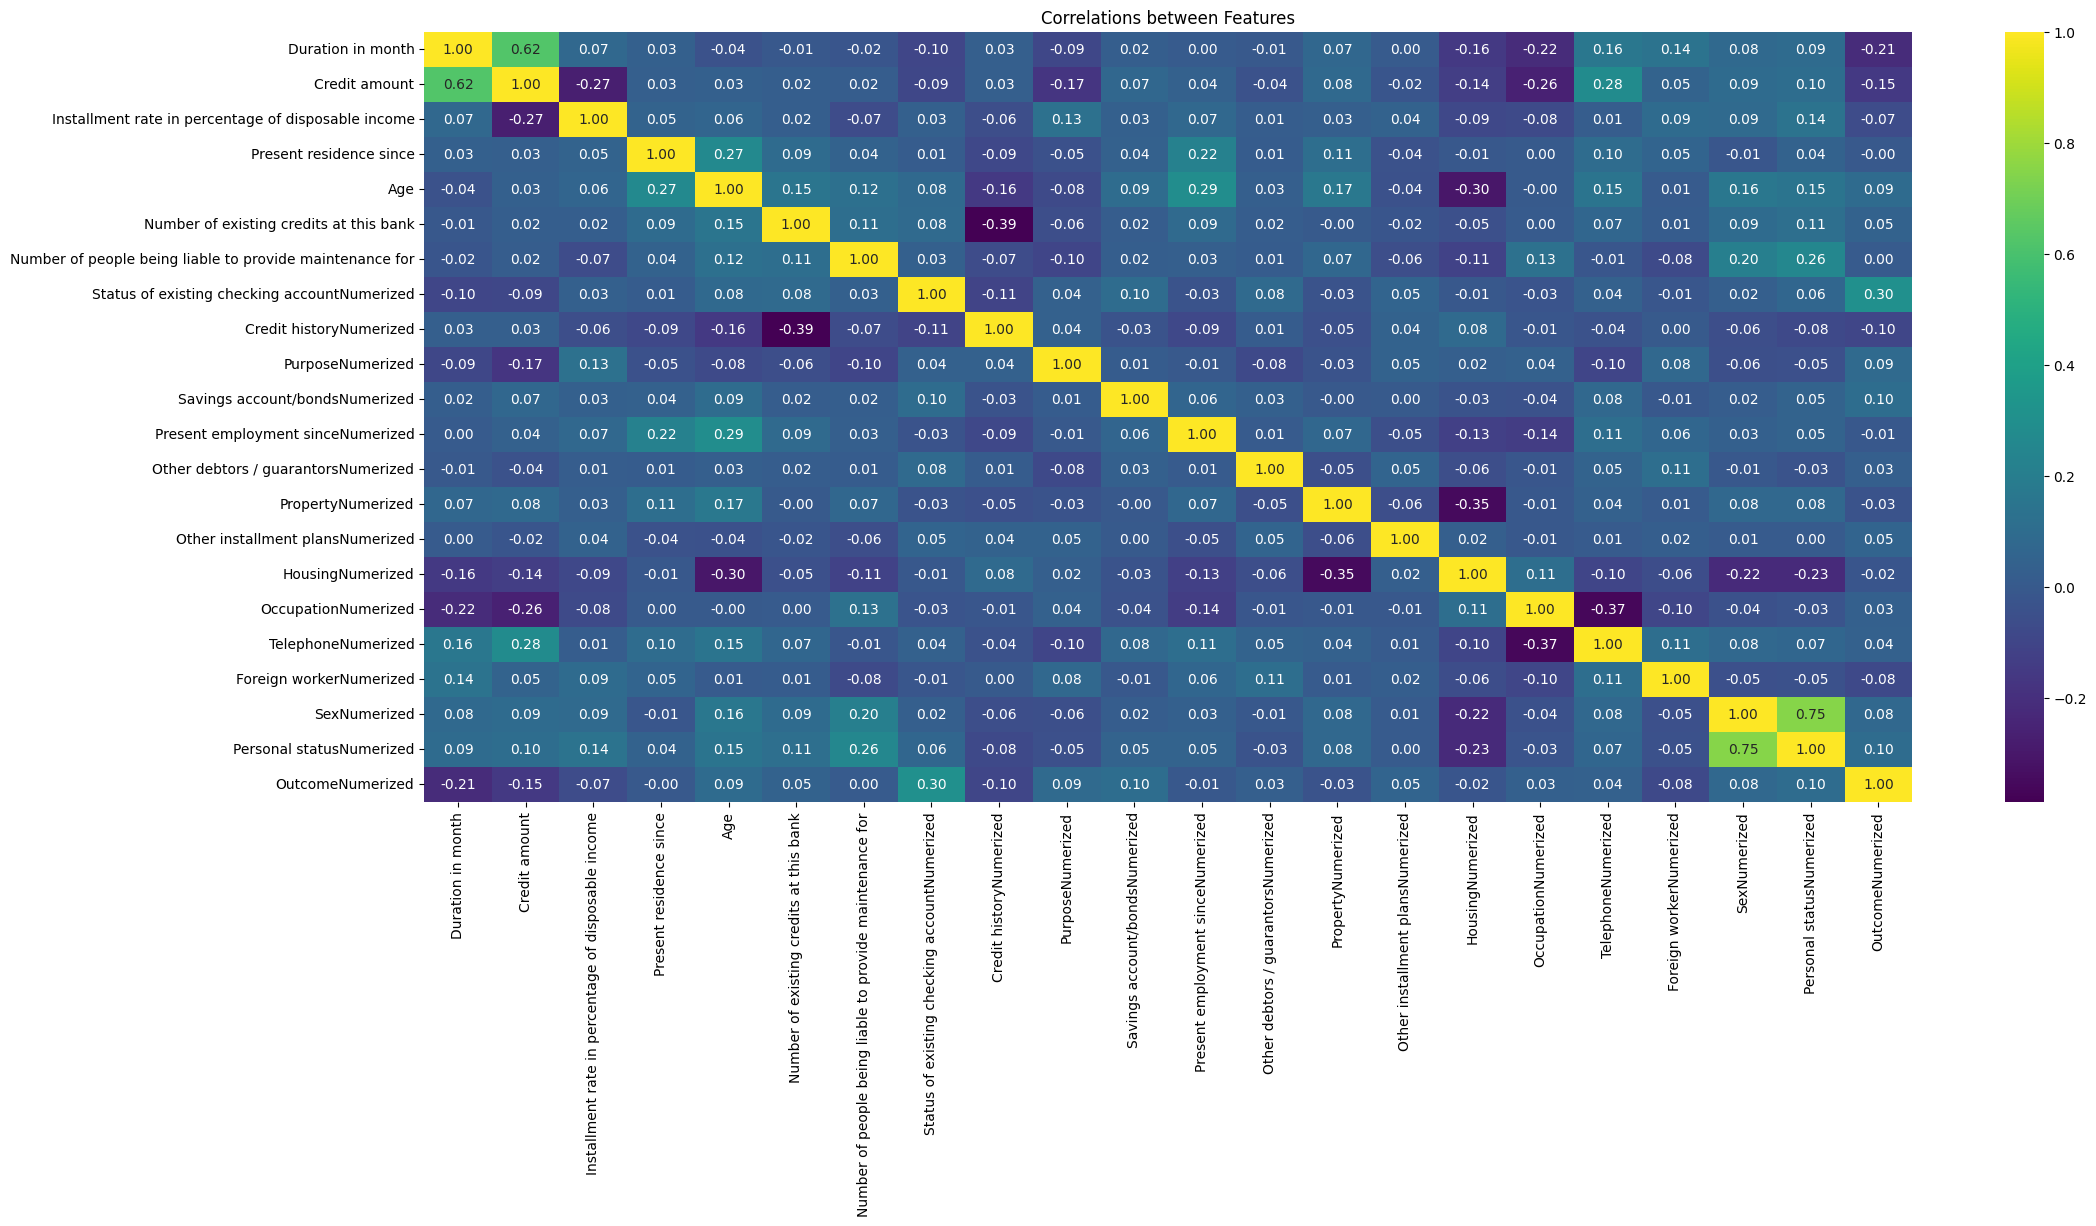

In [7]:
# Preserving initial dataframe for further Exploration
german_numerized = german


# Adjust categorical variables to Numerical values 
num_var = [
    'Status of existing checking account',
    'Credit history',
    'Purpose',
    'Savings account/bonds',
    'Present employment since',
    'Other debtors / guarantors',
    'Property',
    'Other installment plans',
    'Housing',
    'Occupation',
    'Telephone',
    'Foreign worker',
    'Sex',
    'Personal status',
    'Outcome'
]

for i in num_var:
    variable_num = i + 'Numerized'
    german_numerized[variable_num] = german_numerized[i].astype('category').cat.codes


# Correlation Heatmap of variables
fig, ax = plt.subplots(figsize=(24, 10))
sns.heatmap(german.corr(numeric_only=True), annot = True, cmap = 'viridis',fmt='.2f')
plt.gca().set_title('Correlations between Features')
plt.show()
plt.close()



Insights drawn from the heatmap:

Highest correlations:
Credit Amount - Duration in Month 0.62
Personal Status - Sex 0.75



Obsolete Feature identified:
Telephone

Features that need removing for ethical reasons:
Age
Sex
Marital Status


In [8]:
german['Telephone']


0      yes, registered under the customers name
1                                          none
2                                          none
3                                          none
4                                          none
                         ...                   
995                                        none
996    yes, registered under the customers name
997                                        none
998    yes, registered under the customers name
999                                        none
Name: Telephone, Length: 1000, dtype: object

# 2. Cleaned dataset with Final Features Exploration

Final dataset preprocessed for Machine Learning Model



In [14]:
# create y variable from cleaned dataset
X_clean = pd.read_csv('/Users/coletteford/Desktop/IGP/Dataset/german_x_20240418.csv')
y_clean = pd.read_csv('/Users/coletteford/Desktop/IGP/Dataset/german_y_20240418.csv')
X_clean.info()





<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                                   Non-Null Count  Dtype
---  ------                                   --------------  -----
 0   credit_amount_group                      1000 non-null   int64
 1   duration_group                           1000 non-null   int64
 2   business                                 1000 non-null   int64
 3   car_new                                  1000 non-null   int64
 4   car_used                                 1000 non-null   int64
 5   domestic_appliances                      1000 non-null   int64
 6   education                                1000 non-null   int64
 7   electronics                              1000 non-null   int64
 8   furniture_equipment                      1000 non-null   int64
 9   others                                   1000 non-null   int64
 10  repairs                                  1000 non-null   int64
 11  retra

Dataset Exploration:

Dataset consists of 23 columns excluding index.

Independent variables are a mixture of bools and Ordinal Categories due to preprocessing. This occludes normal summary statistics.

Dependent variable are integers - Calculated Credit Score.

Reviewing X in BBEdit observations:

Variables that are still Ordinal Categories, the rest are bools: 

0 credit_amount_group
1 duration_group
12 disposible_income_group
13 number_of_existing_credits_at_this_bank
14 status_of_existing_checking_account
15 credit_history
21 employment_length
22 housing
23 number_of_dependents
Number_of_dependents

Comparison to raw data

Dropped:

Installment rate in percentage of disposible income
present residence since
Savings account/bonds
Telephone
Foreign worker
Personal status and sex
Sex
Personal status
Outcome
Risk(Outcome_text)
Risk(Outcome_text)

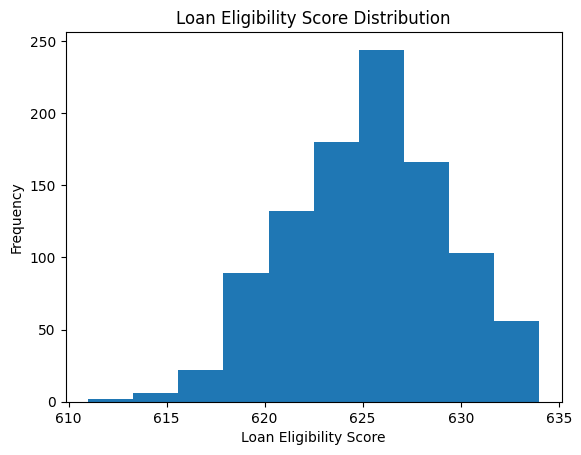

<Figure size 640x480 with 0 Axes>

In [15]:
# Initial exploring of target variable distribution

plt.hist(y_clean)
plt.title('Loan Eligibility Score Distribution')
plt.xlabel('Loan Eligibility Score')
plt.ylabel('Frequency')
plt.show()
plt.clf()

Comments on Loan Eligibility Score distribution:

Left skewed, negative skew distribution.




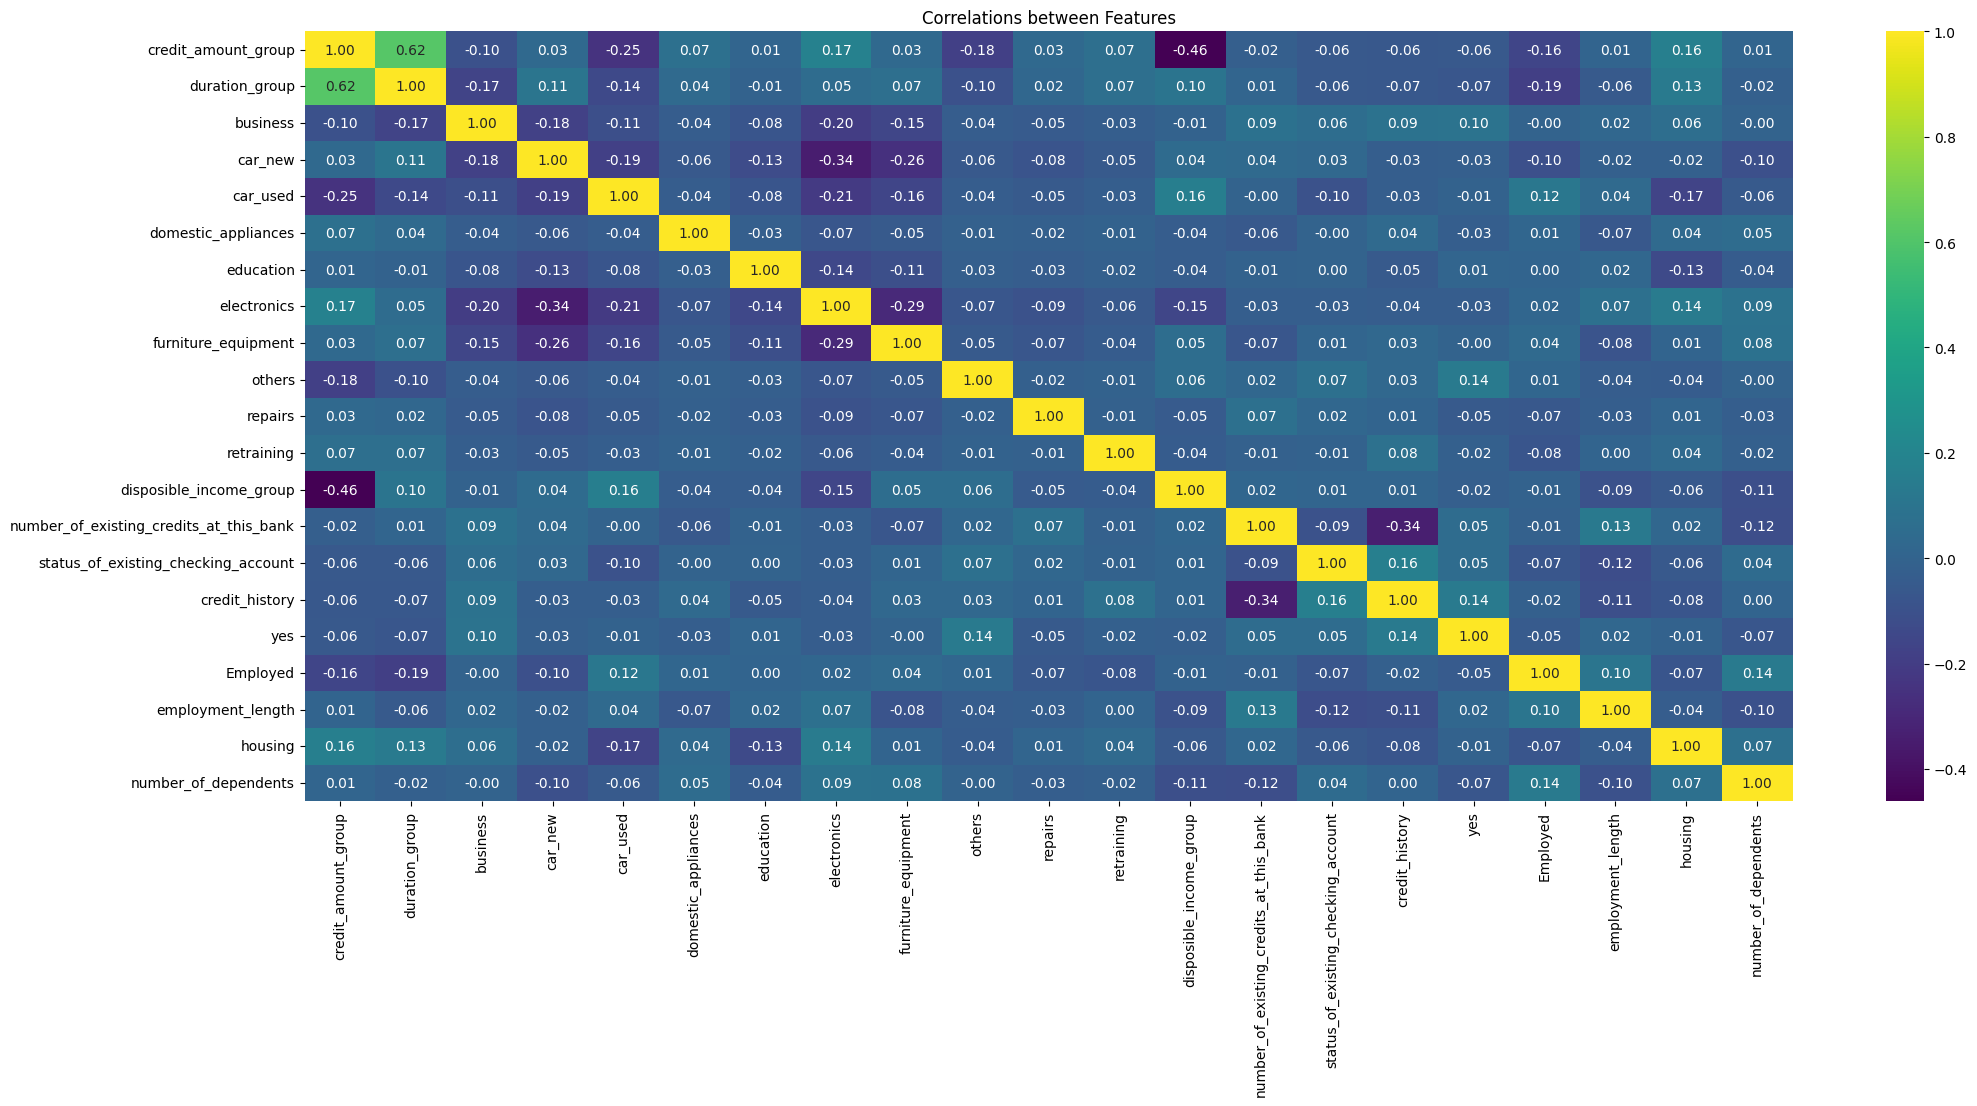

In [16]:
# Correlation map
fig, ax = plt.subplots(figsize=(24, 10))
sns.heatmap(X_clean.corr(numeric_only = True), annot = True, cmap = 'viridis',fmt='.2f')
plt.gca().set_title('Correlations between Features')
plt.show()
plt.close()

Insight from correlation mapping:

Low correlation between most variables

significant correlations between:
duration_group / credit_amount_group

Binary columns that have been broken down during preprocessing, will remove 'No' and 'Unemployed from dataset for Predictive Modelling:

Employed / Unemployed
Yes / No


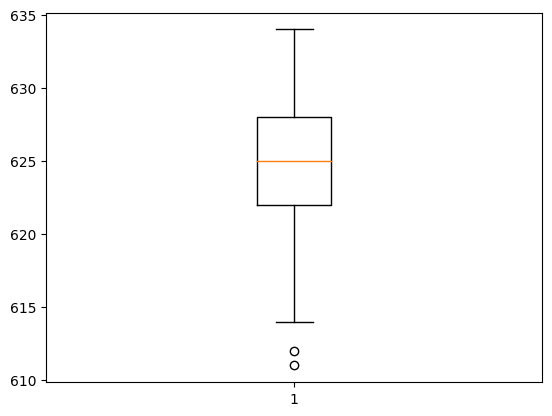

In [17]:

# Further exploration:

# Simple boxplot
plt.boxplot(y_clean)
plt.show()
plt.close()





Feature Importance Section

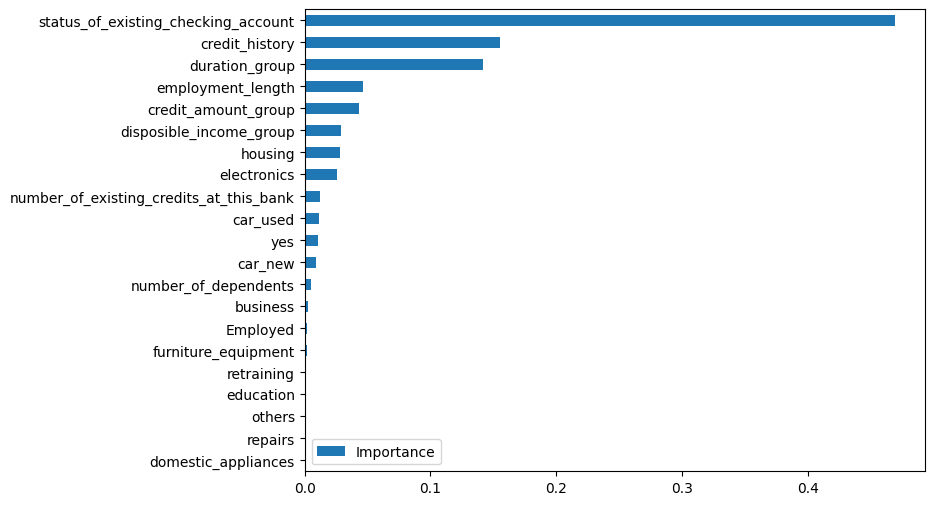

                                         Importance
domestic_appliances                        0.000369
repairs                                    0.000626
others                                     0.001081
education                                  0.001088
retraining                                 0.001367
furniture_equipment                        0.002165
Employed                                   0.002286
business                                   0.002780
number_of_dependents                       0.004836
car_new                                    0.009242
yes                                        0.010993
car_used                                   0.011137
number_of_existing_credits_at_this_bank    0.012213
electronics                                0.026140
housing                                    0.028151
disposible_income_group                    0.029176
credit_amount_group                        0.043059
employment_length                          0.046288
duration_gro

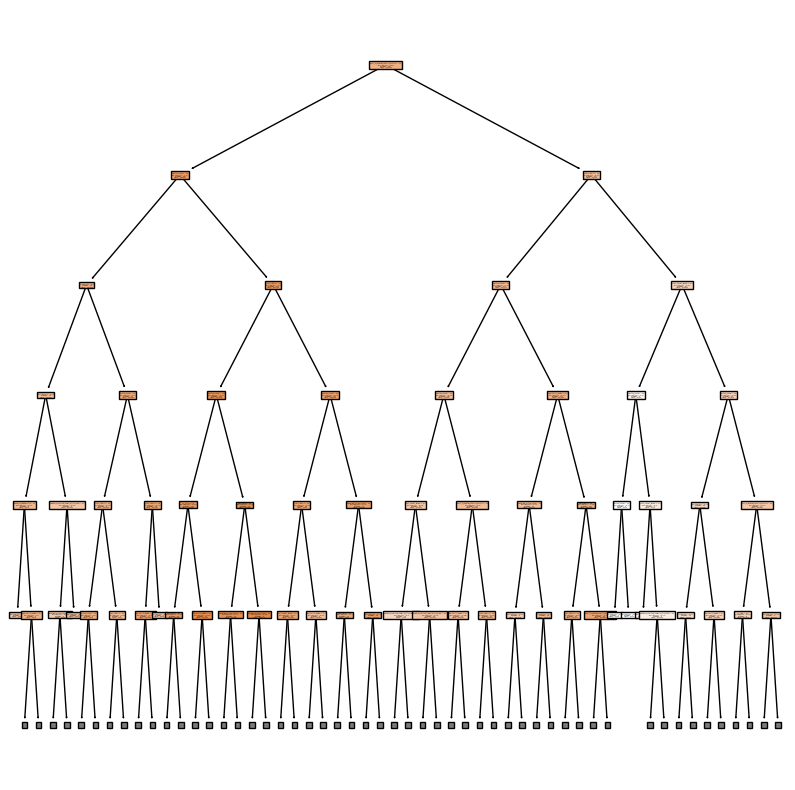

In [26]:
# Exploring Feature Selection across datasets and transformations:


X_train, X_test, y_train, y_test = train_test_split(X_clean, y_clean, random_state = 42, test_size= 0.2)

dtree = DecisionTreeRegressor()
dtree.fit(X_train, y_train)
feat_importances = pd.DataFrame(dtree.feature_importances_, index=X_train.columns, columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=True, inplace=True)
feat_importances.plot(kind='barh', figsize=(8,6))
plt.show()
plt.close()
# Feature Importance in Raw Dataset:
print(feat_importances)

plt.figure(figsize=(10,10))
tree.plot_tree(dtree, feature_names=list(X_clean), max_depth=5, filled=True)
plt.savefig('fig1.svg', format='svg')
# Feature Importance in cleaned Regression Dataset:


# Observations of Feature Importance:

Feature with highest importance:

status_of_existing_checking_account

Features below usual importance threshold:
domestic_appliances
repairs
others
edication
retraining
furniture_equipment
business
Employed
number_of_dependents
car_new


This is a concern when using Decision Trees as categorical variables have been translated to indicator variables, when separated the impact of each category is valued separately rather than as part of the whole categorical feature.

# Observations of tree

tree saved as .svg document, as in view version lacks detail.
MSE used for splitting.